# Case 1
Otso Pohjola<br>
Last edited: 02.02.2018<br>
Cognitive Systems for Health Technology Applications<br>
[Helsinki Metropolia University of Applied Sciences](http://www.metropolia.fi/en/)<br>

## 1. Objectives

The goal is to see if it's possible to spot a heart disease by using a neural network, so that it could be possibly used in the medical field if the outcome is found succesfull.

## 2. Required libraries

In [35]:
# -*- coding: utf-8 -*-
"""
Created on Fri Jan 19 13:02:00 2018

@author: Otso
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras as krs
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
%matplotlib inline

## 3. Data description and preprocessing

See https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/heart-disease.names for a detailed description of the data.

I used all four preprocessed data collections which were combined to a larger dataset. The data was normalized and the missing values were replaced by the mean value of that column. I also mixed the rows, since it gives more variety between train and test data. There are histograms of each variable in the end of this chapter.

<h4>Preprocessing the outputs</h4><br/>
I tried three different ways of preprocessing the data. The first was a multiclass approach where the outputs were divided in five binary values ([0,0,0,0,0]) and then predicted those using categorical crossentropy as a loss function. The results weren't that good (got validation accuracy of 60%) and I learned this was not what was wanted from this assignment.

After hearing the output should be treated as a single binary output, I checked the data description linked above and ended up dividing it in the following way: "num" values 1 and 2 were changed to 0, since they meant the propability of a heart disease was under 50%. Additionally, values 3 and 4 were changed to 1. The reasoning behind this was the description of the "num" attribute: 
"58 num: diagnosis of heart disease (angiographic disease status)
        -- Value 0: < 50% diameter narrowing
        -- Value 1: > 50% diameter narrowing"
This way I got nearly 90% validation accuracy.

But since the goal was to predict if there's any disease at all, I ended up changing all the output values to 1 except 0.


In [36]:
#Initialize  the links
clevelandLink = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
hungarianLink = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data'
switzerlandLink = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data'
vaLink = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.va.data'
colnames = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num']

#Read the data
clevelandData = pd.read_csv(clevelandLink,names=colnames,na_values='?') #names = colnames,na_values = '?'
hungarianData = pd.read_csv(hungarianLink,names=colnames,na_values='?')
switzerlandData = pd.read_csv(switzerlandLink,names=colnames,na_values='?')
vaData = pd.read_csv(vaLink,names=colnames,na_values='?')

#Create a big DataFrame with all the data combined.
frames = [pd.DataFrame(clevelandData),
          pd.DataFrame(hungarianData),
          pd.DataFrame(switzerlandData),
          pd.DataFrame(vaData)]
df = pd.concat(frames)

#Replace missing values with mean values
df = df.where(~np.isnan(df),df.mean(),axis = 'columns')

#Scramble the dataframe rows
np.random.seed(6)
df = df.iloc[np.random.permutation(len(df))]
df = df.reset_index(drop=True);

#Store the predicted values separately
predValues = df['num']
#and change them to binary values
predValues = predValues.replace(1,1)
predValues = predValues.replace(4,1)
predValues = predValues.replace(3,1)
predValues = predValues.replace(2,1)


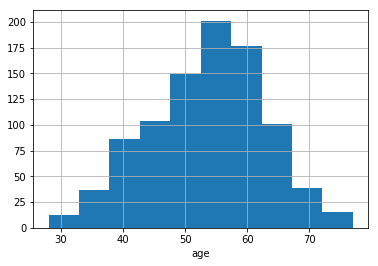

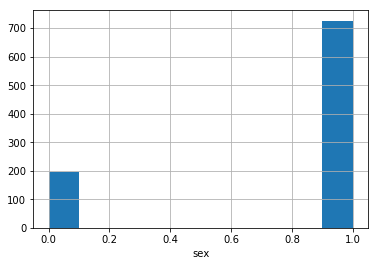

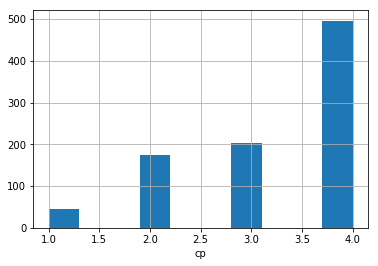

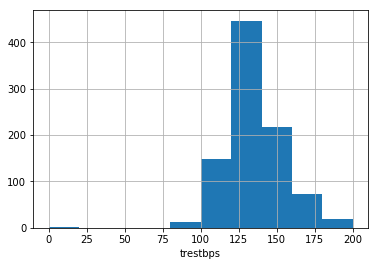

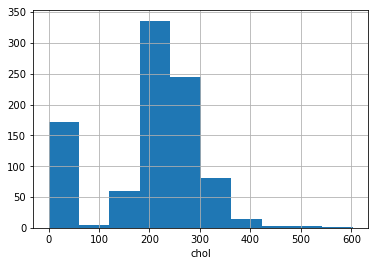

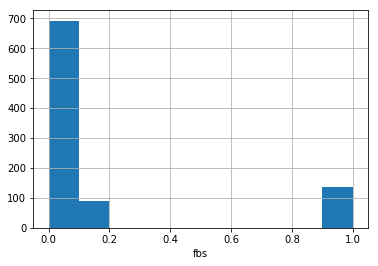

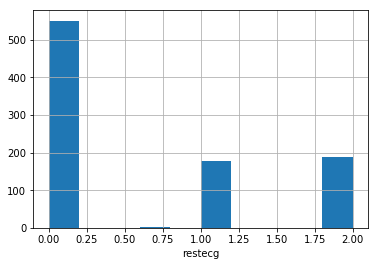

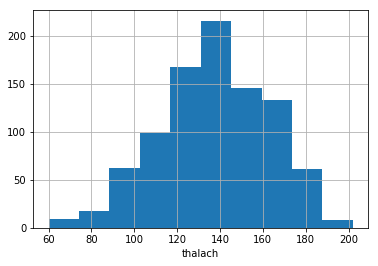

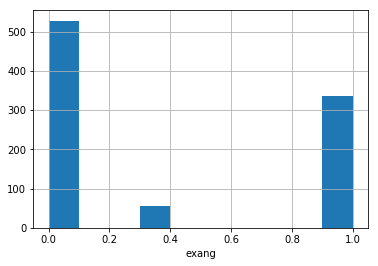

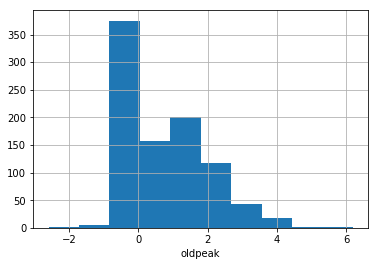

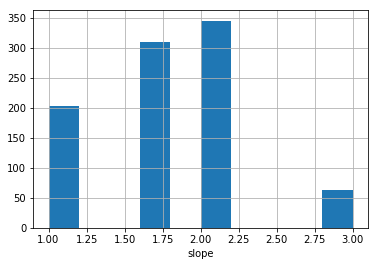

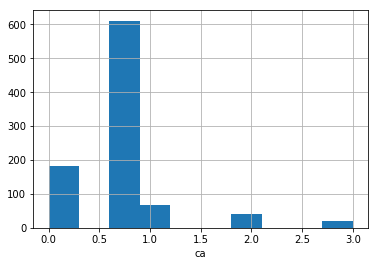

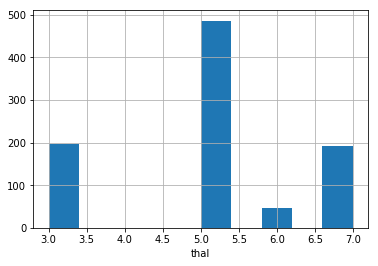

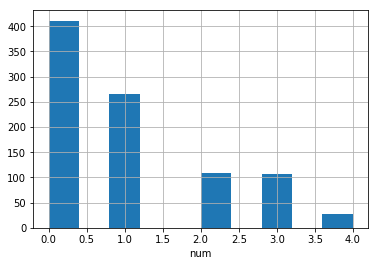

In [37]:
#Plot the histograms for the data
for column in df.columns:
    fig = plt.figure()
    hist = df[column].hist()
    histPlt = fig.add_subplot(hist)
    histPlt.set_xlabel(column)
    histPlt.plot()
    



There seems to be way more men than women in this dataset, which means we probably couldn't use the results straight away in women's healthcare.

In [38]:
#Remove output values from the DataFrame
del df['num']

#Normalize
df = (df - df.mean()) / (df.max() - df.min()) 

#Other way to normalize:
#min_max_scaler = preprocessing.MinMaxScaler()
#data_minmax = min_max_scaler.fit_transform(data)
#data_minmax

## 4. Modeling and compilation




The data was split in train and test sets, the training set has 70% of the materials and the test 30%. So it's a split validation. <br/><br/>
For the network's topology only one hidden layer was used, as adding a second or third one didn't have a positive impact.The hidden layer's size is decided by the hLayerSize -variable and its activation function is RELU. The input layer consists of 13 values and the output layer has only one binary node. The network is also running quite many epochs and using a small learning rate, as I find this approach the most steady. The loss function used is  Binary crossentropy and the optimizer is SGD.

Of course I experimented with different parameters and functions, and these values are just the conclusion of many trials and errors.

In [39]:
#Initialize the training set
ntrain = int(0.7*df.shape[0]) # 70% for training, 30% for testing
train_data = df.values[:ntrain]
train_outputs = predValues[:ntrain]
test_data = df.values[ntrain:]
test_outputs = predValues[ntrain:]

#Other way of splitting the data
#x_train, x_test, y_train, y_test = train_test_split(
#   data_minmax, labels, test_size=0.36)


In [40]:
hLayerSize = (int)(ntrain/(2*(13+1)))
#Training
model = Sequential()
model.add(Dense(units=hLayerSize, activation='relu', input_dim=13))
model.add(Dense(units=1, activation='sigmoid'))

epochs = 1300;
model.compile(
        loss=krs.losses.binary_crossentropy,
        optimizer=krs.optimizers.SGD(lr=0.0095),
        metrics = ['accuracy'])


## 5. Training and Validation

Batch size of 32 was used for training, I think it's a reasonable size when there's quite a few rows to go through.

In [41]:
history = model.fit(
                train_data,
                train_outputs,
                epochs=epochs,
                batch_size=32,
                verbose = 0,
                validation_data = (test_data,test_outputs))


## 6. Evaluation

The validation accuracy was 85.7% at its best which is quite accurate. By gathering more data or developing the neural network further the result could be even better. 

In [48]:
score = model.evaluate(test_data, test_outputs, batch_size=16)
print("Validation error: " + str(score[0]))
print("Validation accuracy: " + str(score[1]))

276/276 [==============================] - 0s 307us/step
Validation error: 0.3660738723
Validation accuracy: 0.847826086957


## 7. Results and Discussion

As seen in the diagrams the accuracy and loss keep steadily getting better and better values until they reach the maximum of ~85,7% and ~0,36. If ran even more epochs the accuracy starts to decrease. The results weren't surprising in any way, since the dataset is very high quality and incredibly vast.

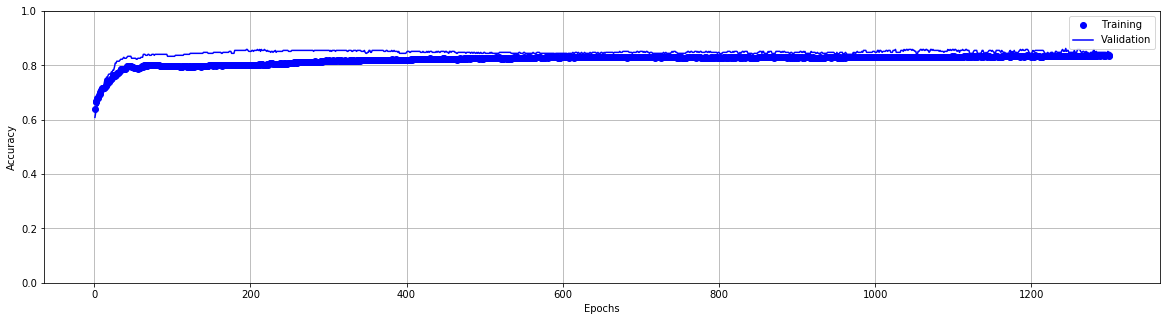

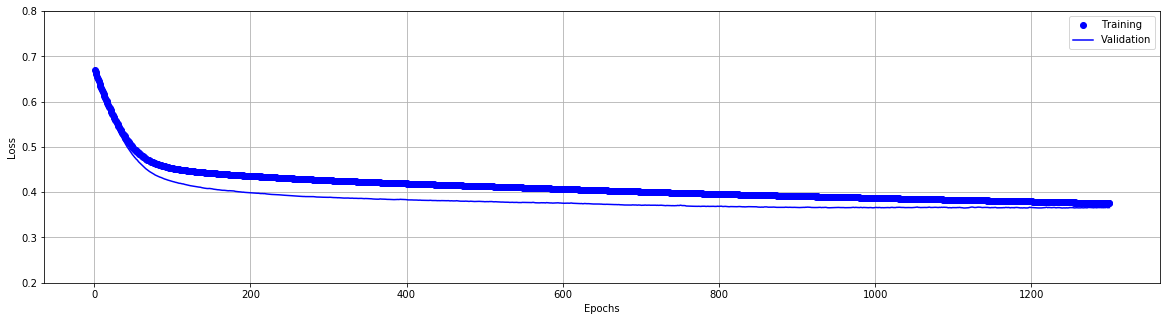

In [43]:
epochsAxel = range(1, epochs + 1)
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Accuracy plot
plt.figure(figsize = (20, 5))
plt.plot(epochsAxel, acc, 'bo', label='Training')
plt.plot(epochsAxel, val_acc, 'b', label = 'Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.grid()
plt.legend()
plt.show()

# Loss plot
plt.figure(figsize = (20, 5))
plt.plot(epochsAxel, loss, 'bo', label='Training')
plt.plot(epochsAxel, val_loss, 'b', label = 'Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0.2, 0.8])
plt.grid()
plt.legend()
plt.show()


## 8. Conclusions

There's no doubt a clear link between the given data and heart disease can be found. I'd probably use other kind of statistical functions to figure out which variables have the biggest part in causing the illness, or the other way to make the result more informative could be by dropping some of the input nodes to see if the outcome gets better. All in all, this network isn't accurate enough to be used in medical examination when trying to determine if the patient has a heart disease or not. In my opiniont the least acceptable accuracy should be 95% so there's still much work to do.